In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.7 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [4]:
%cd /content/drive/MyDrive/IS403/Project/Data/

/content/drive/.shortcut-targets-by-id/1H00NdDTisvXwJcMmLshBS2Qn7PUvkU8H/IS403/Project/Data


# Eval Function

In [5]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [6]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [7]:
def train_test_valid(data):
  test_size  = 0.3
  valid_size = 0.2

  test_split_idx  = int(data.shape[0] * (1-test_size))
  valid_split_idx = int(data.shape[0] * (1-(valid_size+test_size)))

  return data[:valid_split_idx], data[valid_split_idx:test_split_idx+1], data[test_split_idx+1:]

# AMAZON

## Data

In [8]:
df_amz = pd.read_csv("AMZN.csv")
df_amz

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,58.602501,58.982498,57.599998,58.117500,58.117500,82142000
1,2017-12-04,58.692501,58.759998,56.400002,56.697498,56.697498,118638000
2,2017-12-05,56.412998,57.963501,56.237000,57.078499,57.078499,81596000
3,2017-12-06,56.899502,57.794498,56.804001,57.617500,57.617500,57066000
4,2017-12-07,57.829498,58.159500,57.549999,57.989498,57.989498,50232000
...,...,...,...,...,...,...,...
1384,2023-06-05,123.360001,125.800003,123.029999,125.300003,125.300003,47950100
1385,2023-06-06,125.070000,127.400002,125.000000,126.610001,126.610001,45695200
1386,2023-06-07,127.010002,127.370003,120.629997,121.230003,121.230003,95663300
1387,2023-06-08,123.010002,125.629997,122.260002,124.250000,124.250000,62159300


## Preprocessing

### Check null and na value

In [9]:
df_amz.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
df_amz.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [11]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Close column data type: ", type(df_amz['Close'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Adj Close column data type: ", type(df_amz['Adj Close'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [12]:
df_amz['Date'] = pd.to_datetime(df_amz.Date)

### Choose X

In [13]:
close_amz=df_amz[['Close']]

## EDA

### Get the duration of dataset

In [14]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])
print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

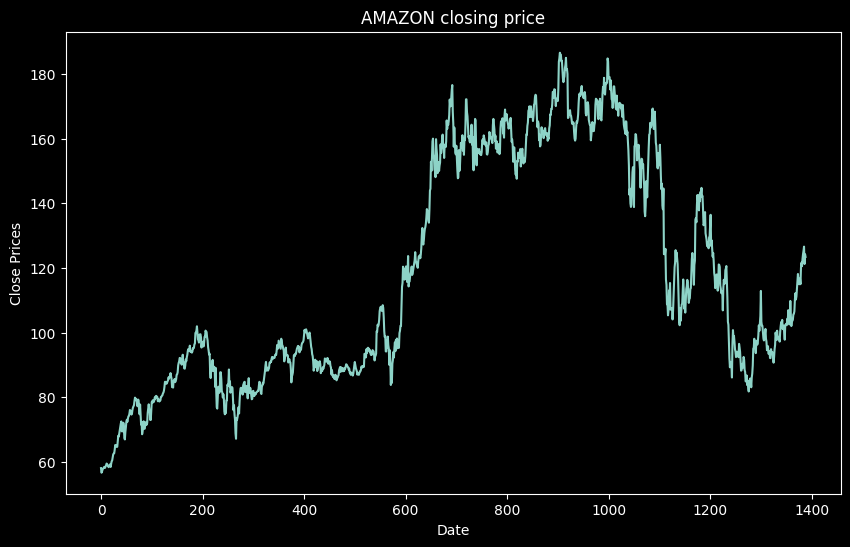

In [15]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(close_amz)
plt.title('AMAZON closing price')
plt.show()

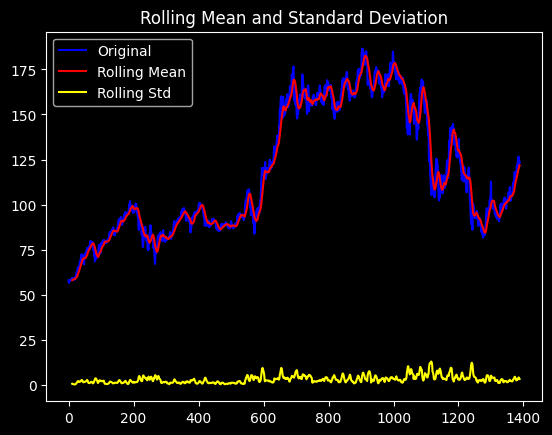

Results of dickey fuller test
Test Statistics                  -1.929368
p-value                           0.318374
No. of lags used                  0.000000
Number of observations used    1388.000000
critical value (1%)              -3.435070
critical value (5%)              -2.863625
critical value (10%)             -2.567880
dtype: float64


In [16]:
test_stationarity(close_amz)

## Train, test, valid

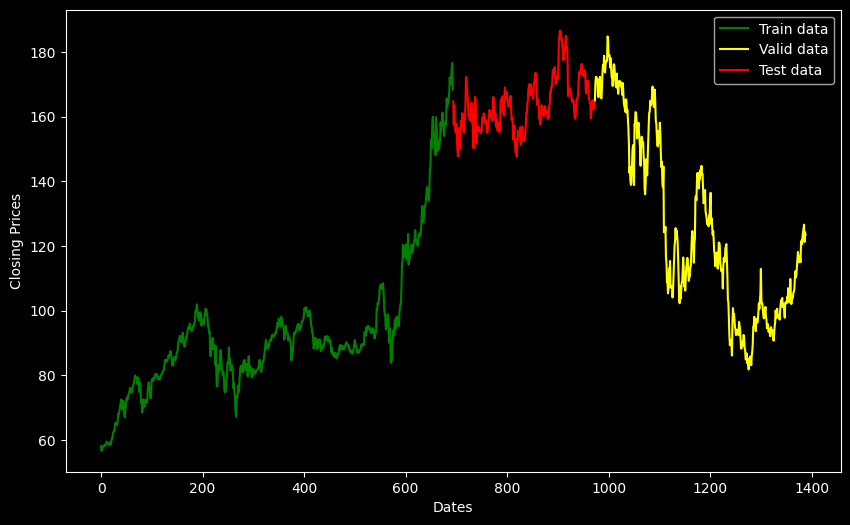

In [17]:
close_amz = close_amz.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_amz)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [18]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [19]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= df_amz[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8315.221, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7376.544, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2938.897, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2944.540, Time=0.49 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2940.416, Time=0.55 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6571.080, Time=1.48 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.40 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2941.343, Time=3.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2938.932, Time=1.82 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 9.651 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  694
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1466.448
Date:                Wed, 21 Jun 2023   AIC                           2938.897
Time:                        03:46:14   BIC                           2952.524
Sample:                             0   HQIC                          2944.167
                                - 694                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   3918.417      0.000       0.999       1.000
ma.L1         -0.0789      0.028     -2.830      0.005      -0.134      -0.024
sigma2         3.9601      0.124     31.926      0.000       3.717       4.203
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               473.92
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.78   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [20]:
model = ARIMA(y_train, order=(1,0,1),exog=df_amz[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  694
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -699.223
Date:                Wed, 21 Jun 2023   AIC                           1412.446
Time:                        03:46:16   BIC                           1444.243
Sample:                             0   HQIC                          1424.742
                                - 694                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0588      0.078      0.755      0.450      -0.094       0.211
High           0.8372      0.017     49.572      0.000       0.804       0.870
Open          -0.6350      0.020    -31.960      0.000      -0.674      -0.596
Low            0.7977      0.013     62.762      0.000       0.773       0.823
ar.L1         -0.1140      0.144     -0.793      0.428      -0.396       0.168
ma.L1         -0.0939      0.145     -0.647      0.518      -0.378       0.190
sigma2         0.4410      0.016     27.867      0.000       0.410       0.472
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               381.58
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.77   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [21]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=df_amz[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1),exog=df_amz[['High','Open','Low']][len(x_train):(int(len(x_val)+x_val[0]))])

In [22]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  0.7732497006681743
MAPE:  0.4781556300163437
RMSE:  1.039885284088729

** Validate **
MAE:  0.886399502587464
MAPE:  0.7171756684791633
RMSE:  1.1482999093736832


## Forecast

In [23]:
last_index =  close_amz.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog=df_amz[['High','Open','Low']][last_index-725:last_index])

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1389    109.389017
1390    106.536382
1391    102.741162
1392    103.302897
1393    105.285284
1394    104.641495
1395    104.996682
1396    105.709742
1397    106.374990
1398    110.265151
1399    112.536217
1400    110.349568
1401    110.642024
1402    114.234453
1403    115.195548
1404    118.062828
1405    116.376096
1406    114.812725
1407    116.335027
1408    116.805830
1409    115.033210
1410    120.648290
1411    120.880897
1412    120.177905
1413    122.480718
1414    125.485305
1415    125.192188
1416    127.017405
1417    122.274538
1418    124.657876
Name: predicted_mean, dtype: float64


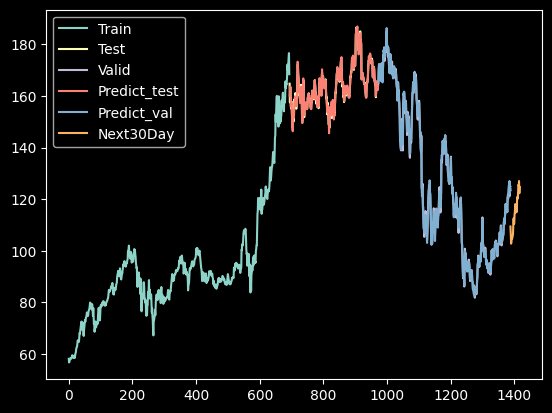

In [24]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()

# NVIDIA

## Data

In [25]:
df_nvda = pd.read_csv("NVDA.csv")
df_nvda

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,49.827499,50.032501,48.117500,49.419998,48.908009,81154800
1,2017-12-04,50.012501,50.075001,46.125000,46.665001,46.181549,124084400
2,2017-12-05,45.599998,48.174999,45.145000,46.935001,46.448750,98148800
3,2017-12-06,46.424999,47.535000,46.209999,47.314999,46.824821,46703200
4,2017-12-07,47.990002,48.400002,47.529999,47.997501,47.500244,54260000
...,...,...,...,...,...,...,...
1384,2023-06-05,389.089996,395.649994,387.070007,391.709991,391.669464,39609400
1385,2023-06-06,388.299988,391.600006,381.480011,386.540009,386.500000,38872900
1386,2023-06-07,389.149994,394.989990,373.559998,374.750000,374.750000,51199800
1387,2023-06-08,377.239990,388.640015,375.049988,385.100006,385.100006,41777200


## Preprocessing

### Check null and na value

In [26]:
df_nvda.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [27]:
df_nvda.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [28]:
print("Date column data type: ", type(df_nvda['Date'][0]))
print("Open column data type: ", type(df_nvda['Open'][0]))
print("Close column data type: ", type(df_nvda['Close'][0]))
print("High column data type: ", type(df_nvda['High'][0]))
print("Low column data type: ", type(df_nvda['Low'][0]))
print("Adj Close column data type: ", type(df_nvda['Adj Close'][0]))
print("Volume column data type: ", type(df_nvda['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [29]:
df_nvda['Date'] = pd.to_datetime(df_nvda.Date)

### Choose X

In [30]:
close_nvda=df_nvda[['Close']]

## EDA

### Get the duration of dataset

In [31]:
print("Starting date: ",df_nvda.iloc[0][0])
print("Ending date: ", df_nvda.iloc[-1][0])
print("Duration: ", df_nvda.iloc[-1][0]-df_nvda.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

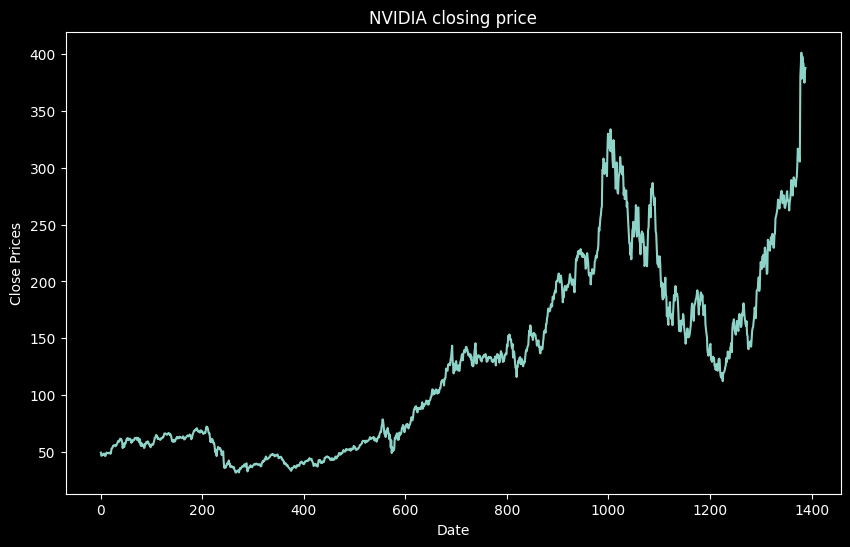

In [32]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(close_nvda)
plt.title('NVIDIA closing price')
plt.show()

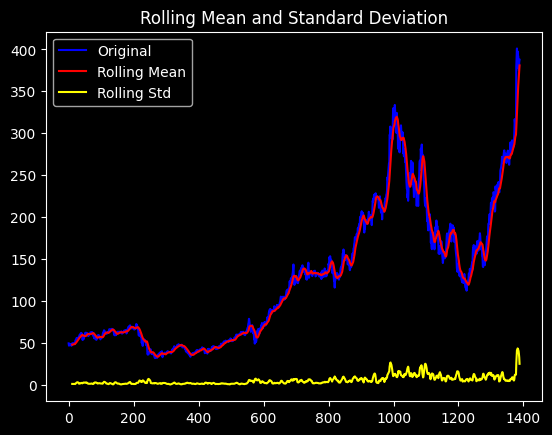

Results of dickey fuller test
Test Statistics                   0.624465
p-value                           0.988203
No. of lags used                 17.000000
Number of observations used    1371.000000
critical value (1%)              -3.435129
critical value (5%)              -2.863650
critical value (10%)             -2.567894
dtype: float64


In [33]:
test_stationarity(close_nvda)

## Train, test, valid

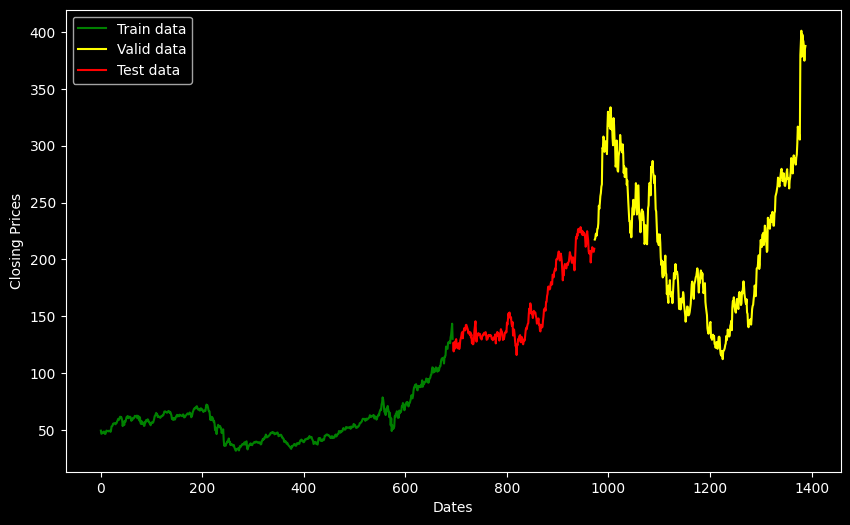

In [34]:
close_nvda = close_nvda.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_nvda)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [35]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [36]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= df_nvda[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7698.270, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6771.712, Time=0.48 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2869.706, Time=0.84 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2887.126, Time=0.86 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2864.089, Time=1.32 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6013.224, Time=3.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2871.846, Time=2.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2865.627, Time=1.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5355.402, Time=3.18 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2860.637, Time=2.42 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=2843.629, Time=1.56 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2842.071, Time=1.98 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2866.979, Time=2.68 sec
 ARIMA(4,0,2)(0,0,0)[0]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  694
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -1413.980
Date:                Wed, 21 Jun 2023   AIC                           2841.959
Time:                        03:47:06   BIC                           2873.757
Sample:                             0   HQIC                          2854.256
                                - 694                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3227      0.658      0.491      0.624      -0.966       1.612
ar.L1         -0.7272      0.033    -22.063      0.000      -0.792      -0.663
ar.L2          0.8056      0.013     63.970      0.000       0.781       0.830
ar.L3          0.9176      0.031     29.582      0.000       0.857       0.978
ma.L1          1.6268      0.045     35.896      0.000       1.538       1.716
ma.L2          0.8049      0.044     18.208      0.000       0.718       0.891
sigma2         3.4135      0.104     32.747      0.000       3.209       3.618
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):              1216.54
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               2.69   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [37]:
model = ARIMA(y_train, order=(3,0,2),exog=df_nvda[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  694
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -664.603
Date:                Wed, 21 Jun 2023   AIC                           1349.206
Time:                        03:47:08   BIC                           1394.631
Sample:                             0   HQIC                          1366.773
                                - 694                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1344      0.066     -2.050      0.040      -0.263      -0.006
High           0.8100      0.018     46.156      0.000       0.776       0.844
Open          -0.5679      0.021    -26.938      0.000      -0.609      -0.527
Low            0.7602      0.013     57.580      0.000       0.734       0.786
ar.L1         -0.1035      0.646     -0.160      0.873      -1.369       1.162
ar.L2         -0.0107      0.471     -0.023      0.982      -0.934       0.913
ar.L3         -0.0432      0.099     -0.437      0.662      -0.237       0.150
ma.L1         -0.1040      0.645     -0.161      0.872      -1.368       1.159
ma.L2         -0.0125      0.526     -0.024      0.981      -1.044       1.019
sigma2         0.3975      0.014     29.372      0.000       0.371       0.424
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               582.89
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.14   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [38]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=df_nvda[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1),exog=df_nvda[['High','Open','Low']][len(x_train):(int(len(x_val)+x_val[0]))])

In [39]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  1.0711906624214287
MAPE:  0.7055184602161283
RMSE:  1.411139688706836

** Validate **
MAE:  2.345423187685137
MAPE:  1.088691659898495
RMSE:  3.1718602302402683


## Forecast

In [40]:
last_index =  close_nvda.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog=df_nvda[['High','Open','Low']][last_index-725:last_index])

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1389    269.570768
1390    275.875386
1391    288.302107
1392    284.036754
1393    280.363763
1394    275.558796
1395    285.554918
1396    290.074232
1397    286.692708
1398    287.308239
1399    284.972547
1400    284.159483
1401    286.615457
1402    297.191589
1403    300.182715
1404    315.451891
1405    311.579117
1406    312.905440
1407    310.091550
1408    302.790519
1409    379.361640
1410    387.402107
1411    412.696977
1412    389.506199
1413    397.133631
1414    397.104372
1415    393.610034
1416    386.528641
1417    382.770517
1418    385.524308
Name: predicted_mean, dtype: float64


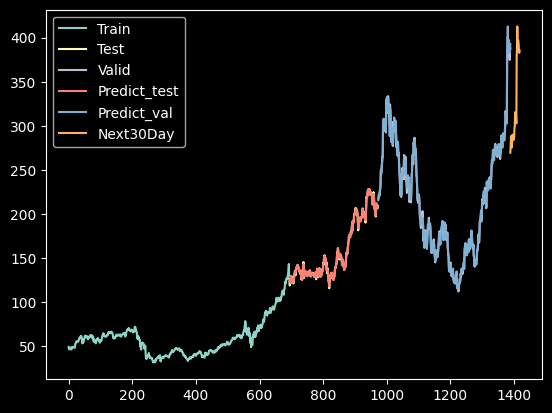

In [41]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()

# TESLA

## Data

In [42]:
df_tsla = pd.read_csv("TSLA.csv")
df_tsla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,20.362667,20.688000,20.336666,20.435333,20.435333,64393500
1,2017-12-04,20.433332,20.551332,20.040667,20.346666,20.346666,87526500
2,2017-12-05,20.133333,20.533333,20.066668,20.246668,20.246668,69697500
3,2017-12-06,20.006666,20.892668,20.000000,20.884001,20.884001,107929500
4,2017-12-07,20.799999,21.242001,20.736668,20.749332,20.749332,71709000
...,...,...,...,...,...,...,...
1384,2023-06-05,217.800003,221.289993,214.520004,217.610001,217.610001,151143100
1385,2023-06-06,216.139999,221.910004,212.529999,221.309998,221.309998,146911600
1386,2023-06-07,228.000000,230.830002,223.199997,224.570007,224.570007,185710800
1387,2023-06-08,224.220001,235.229996,223.009995,234.860001,234.860001,164489700


## Preprocessing

### Check null and na value

In [43]:
df_tsla.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [44]:
df_tsla.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [45]:
print("Date column data type: ", type(df_tsla['Date'][0]))
print("Open column data type: ", type(df_tsla['Open'][0]))
print("Close column data type: ", type(df_tsla['Close'][0]))
print("High column data type: ", type(df_tsla['High'][0]))
print("Low column data type: ", type(df_tsla['Low'][0]))
print("Adj Close column data type: ", type(df_tsla['Adj Close'][0]))
print("Volume column data type: ", type(df_tsla['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [46]:
df_tsla['Date'] = pd.to_datetime(df_tsla.Date)

### Choose X

In [47]:
close_tsla=df_tsla[['Close']]

## EDA

### Get the duration of dataset

In [48]:
print("Starting date: ",df_tsla.iloc[0][0])
print("Ending date: ", df_tsla.iloc[-1][0])
print("Duration: ", df_tsla.iloc[-1][0]-df_tsla.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

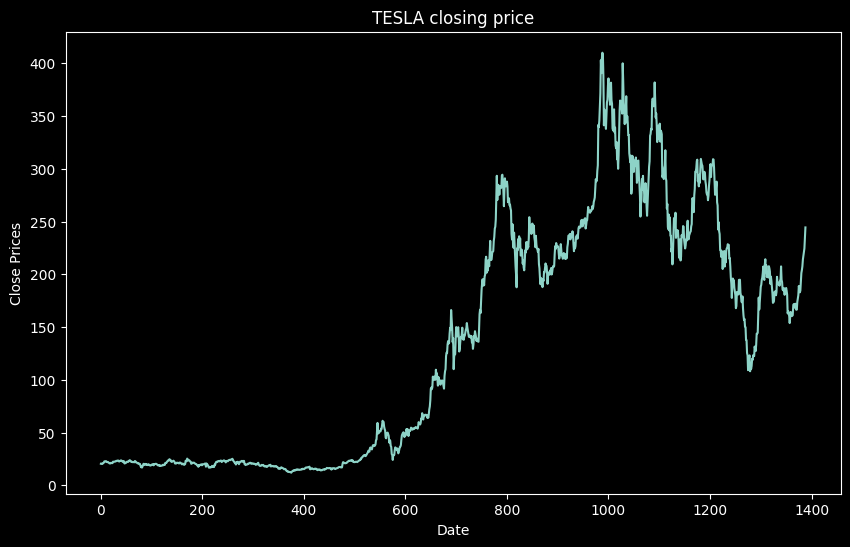

In [49]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(close_tsla)
plt.title('TESLA closing price')
plt.show()

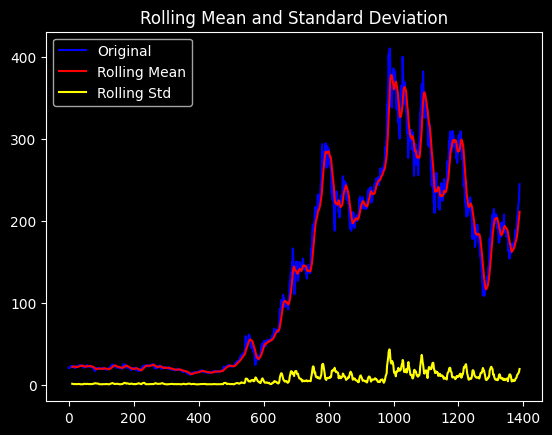

Results of dickey fuller test
Test Statistics                  -1.267376
p-value                           0.643963
No. of lags used                 24.000000
Number of observations used    1364.000000
critical value (1%)              -3.435153
critical value (5%)              -2.863661
critical value (10%)             -2.567899
dtype: float64


In [50]:
test_stationarity(close_tsla)

## Train, test, valid

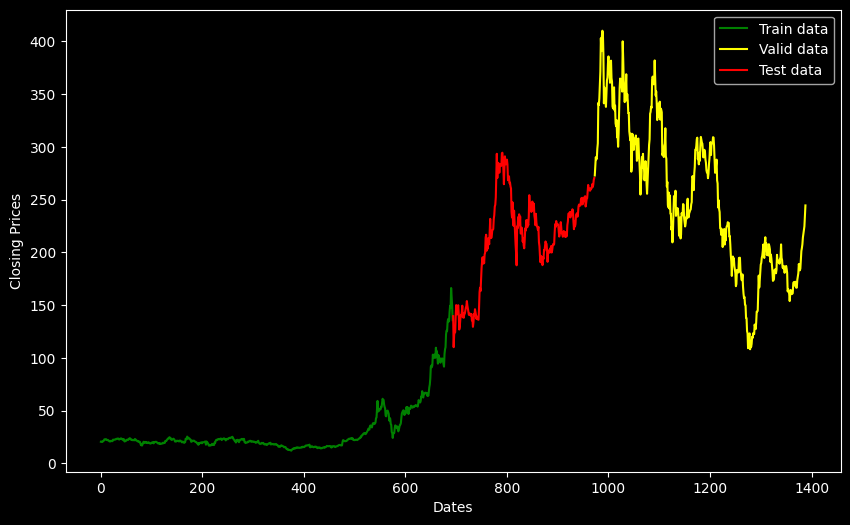

In [51]:
close_tsla = close_tsla.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_tsla)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [52]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [53]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= df_tsla[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7084.873, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2997.910, Time=0.56 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2998.952, Time=0.34 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5415.645, Time=0.52 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.97 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2998.710, Time=0.58 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 5.080 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  694
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1495.955
Date:                Wed, 21 Jun 2023   AIC                           2997.910
Time:                        03:47:16   BIC                           3011.538
Sample:                             0   HQIC                          3003.180
                                - 694                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.001   1950.039      0.000       0.999       1.001
ma.L1          0.0455      0.015      2.994      0.003       0.016       0.075
sigma2         4.3162      0.073     59.495      0.000       4.174       4.458
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             11369.28
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              22.47   Skew:                             1.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [54]:
model = ARIMA(y_train, order=(1,0,1),exog=df_tsla[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  694
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -734.818
Date:                Wed, 21 Jun 2023   AIC                           1483.636
Time:                        03:47:17   BIC                           1515.433
Sample:                             0   HQIC                          1495.932
                                - 694                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0809      0.054     -1.493      0.135      -0.187       0.025
High           0.7664      0.008     99.398      0.000       0.751       0.781
Open          -0.4993      0.007    -72.747      0.000      -0.513      -0.486
Low            0.7363      0.006    125.154      0.000       0.725       0.748
ar.L1         -0.2369      0.036     -6.523      0.000      -0.308      -0.166
ma.L1         -0.1134      0.037     -3.063      0.002      -0.186      -0.041
sigma2         0.4851      0.009     53.080      0.000       0.467       0.503
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             41955.34
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              23.45   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [55]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=df_tsla[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1),exog=df_tsla[['High','Open','Low']][len(x_train):(int(len(x_val)+x_val[0]))])

In [56]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  2.1012731795350117
MAPE:  1.0157054517236002
RMSE:  2.7609798476418463

** Validate **
MAE:  3.1164201733360537
MAPE:  1.22676658726573
RMSE:  4.055353994832606


## Forecast

In [57]:
last_index =  close_tsla.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog=df_tsla[['High','Open','Low']][last_index-725:last_index])

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1389    158.886996
1390    161.871688
1391    160.531937
1392    162.943329
1393    164.222996
1394    161.112431
1395    169.333851
1396    170.954870
1397    168.349760
1398    170.173764
1399    171.517864
1400    171.082136
1401    167.467905
1402    168.140262
1403    172.669900
1404    175.603914
1405    180.720732
1406    187.404442
1407    191.239935
1408    181.340423
1409    182.888137
1410    195.813715
1411    202.162982
1412    200.142133
1413    206.351732
1414    215.929403
1415    218.718233
1416    218.556991
1417    227.327906
1418    232.447341
Name: predicted_mean, dtype: float64


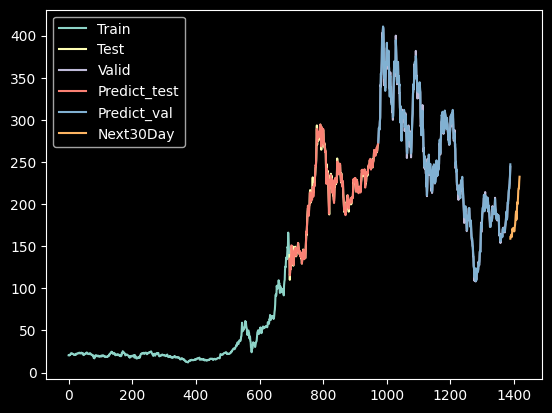

In [58]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()